In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

sns.set_context('talk')

# 1. Business Understanding

Data mining objectives:
- identify key features that are associated with cancelled bookings
- create a model to predict booking cancellation

Aim: $\geq$ 80% accuracy

# 2. Data Understanding

## 2.1. Data Collection

Source: [hotel demand datasets](https://ars.els-cdn.com/content/image/1-s2.0-S2352340918315191-mmc2.zip) from Antonio, et al. (2019).

Paper: Antonio, N., De Almeida, A., & Nunes, L. (2019). Hotel booking demand datasets. Data in Brief, 22, 41-49. https://doi.org/10.1016/j.dib.2018.11.126

## 2.2. Data Description

In [2]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('business-data-understanding').getOrCreate()

/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/cloudpickle.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if obj.__module__ is "__builtin__":


In [3]:
# Import data with automatically configured schema
df_h1 = spark.read.csv('H1.csv', header=True, inferSchema=True)
df_h2 = spark.read.csv('H2.csv', header=True, inferSchema=True)

### Preview of the dataset

In [4]:
df_h1.printSchema()

root
 |-- IsCanceled: integer (nullable = true)
 |-- LeadTime: integer (nullable = true)
 |-- ArrivalDateYear: integer (nullable = true)
 |-- ArrivalDateMonth: string (nullable = true)
 |-- ArrivalDateWeekNumber: integer (nullable = true)
 |-- ArrivalDateDayOfMonth: integer (nullable = true)
 |-- StaysInWeekendNights: integer (nullable = true)
 |-- StaysInWeekNights: integer (nullable = true)
 |-- Adults: integer (nullable = true)
 |-- Children: integer (nullable = true)
 |-- Babies: integer (nullable = true)
 |-- Meal: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- MarketSegment: string (nullable = true)
 |-- DistributionChannel: string (nullable = true)
 |-- IsRepeatedGuest: double (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookingsNotCanceled: integer (nullable = true)
 |-- ReservedRoomType: string (nullable = true)
 |-- AssignedRoomType: string (nullable = true)
 |-- BookingChanges: integer (nullable = true)
 |-- Depos

In [5]:
df_h2.printSchema()

root
 |-- IsCanceled: integer (nullable = true)
 |-- LeadTime: integer (nullable = true)
 |-- ArrivalDateYear: integer (nullable = true)
 |-- ArrivalDateMonth: string (nullable = true)
 |-- ArrivalDateWeekNumber: integer (nullable = true)
 |-- ArrivalDateDayOfMonth: integer (nullable = true)
 |-- StaysInWeekendNights: integer (nullable = true)
 |-- StaysInWeekNights: integer (nullable = true)
 |-- Adults: integer (nullable = true)
 |-- Children: string (nullable = true)
 |-- Babies: integer (nullable = true)
 |-- Meal: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- MarketSegment: string (nullable = true)
 |-- DistributionChannel: string (nullable = true)
 |-- IsRepeatedGuest: double (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookingsNotCanceled: integer (nullable = true)
 |-- ReservedRoomType: string (nullable = true)
 |-- AssignedRoomType: string (nullable = true)
 |-- BookingChanges: integer (nullable = true)
 |-- Deposi

In [6]:
df_h1.head(1)[0].asDict()

{'IsCanceled': 0,
 'LeadTime': 342,
 'ArrivalDateYear': 2015,
 'ArrivalDateMonth': 'July',
 'ArrivalDateWeekNumber': 27,
 'ArrivalDateDayOfMonth': 1,
 'StaysInWeekendNights': 0,
 'StaysInWeekNights': 0,
 'Adults': 2,
 'Children': 0,
 'Babies': 0,
 'Meal': 'BB       ',
 'Country': 'PRT',
 'MarketSegment': 'Direct',
 'DistributionChannel': 'Direct',
 'IsRepeatedGuest': 0.0,
 'PreviousCancellations': 0,
 'PreviousBookingsNotCanceled': 0,
 'ReservedRoomType': 'C               ',
 'AssignedRoomType': 'C               ',
 'BookingChanges': 3,
 'DepositType': 'No Deposit     ',
 'Agent': '       NULL',
 'Company': '       NULL',
 'DaysInWaitingList': 0,
 'CustomerType': 'Transient',
 'ADR': 0.0,
 'RequiredCarParkingSpaces': 0,
 'TotalOfSpecialRequests': 0,
 'ReservationStatus': 'Check-Out',
 'ReservationStatusDate': datetime.datetime(2015, 7, 1, 0, 0)}

In [7]:
df_h2.head(1)[0].asDict()

{'IsCanceled': 0,
 'LeadTime': 6,
 'ArrivalDateYear': 2015,
 'ArrivalDateMonth': 'July',
 'ArrivalDateWeekNumber': 27,
 'ArrivalDateDayOfMonth': 1,
 'StaysInWeekendNights': 0,
 'StaysInWeekNights': 2,
 'Adults': 1,
 'Children': '0',
 'Babies': 0,
 'Meal': 'HB       ',
 'Country': 'PRT',
 'MarketSegment': 'Offline TA/TO',
 'DistributionChannel': 'TA/TO',
 'IsRepeatedGuest': 0.0,
 'PreviousCancellations': 0,
 'PreviousBookingsNotCanceled': 0,
 'ReservedRoomType': 'A               ',
 'AssignedRoomType': 'A               ',
 'BookingChanges': 0,
 'DepositType': 'No Deposit     ',
 'Agent': '          6',
 'Company': '       NULL',
 'DaysInWaitingList': 0,
 'CustomerType': 'Transient',
 'ADR': 0.0,
 'RequiredCarParkingSpaces': 0,
 'TotalOfSpecialRequests': 0,
 'ReservationStatus': 'Check-Out',
 'ReservationStatusDate': datetime.datetime(2015, 7, 3, 0, 0)}

### Generate summary statistics

We only compute summary of numeric columns that are considered meaningful in our analysis.

In [8]:
excluded_cols = [
    'IsCanceled','ArrivalDateYear','ArrivalDateWeekNumber',
    'ArrivalDateDayOfMonth','IsRepeatedGuest','BookingChanges'
]

numeric_cols = [item[0] for item in df_h1.dtypes if (item[1] != 'string') & (item[1] != 'timestamp')]
selected_cols = list(set(numeric_cols) - set(excluded_cols))

## generate summary statistics using describe()
## returns count, mean, stddev, min, max
df_desc_h1 = df_h1.select(selected_cols).describe().toPandas().set_index("summary").transpose()
df_desc_h2 = df_h2.select(selected_cols).describe().toPandas().set_index("summary").transpose()

In [9]:
from pyspark.sql import SQLContext

sql_con = SQLContext(spark)
df_h1.createOrReplaceTempView('df_h1')
df_h2.createOrReplaceTempView('df_h2')

h1_median = {}
h2_median = {}

## calculate median of the relevant columns
for src in ['df_h1', 'df_h2']:
    for col in selected_cols:
        MEDIAN_QUERY = "select percentile_approx({0}, 0.5) as {0} from {1}".format(col, src)
        val = sql_con.sql(MEDIAN_QUERY).collect()[0][0]
        if 'h1' in src:
            h1_median[col] = val
        else:
            h2_median[col] = val
            
df_median_h1 = pd.DataFrame(h1_median, index=['median']).transpose()
df_median_h2 = pd.DataFrame(h2_median, index=['median']).transpose()

In [10]:
## combine with describe() results
df_desc_ext_h1 = pd.merge(
    df_desc_h1,
    df_median_h1,
    left_index = True,
    right_index = True
)

df_desc_ext_h2 = pd.merge(
    df_desc_h2,
    df_median_h2,
    left_index = True,
    right_index = True
)

display(df_desc_ext_h1)
display(df_desc_ext_h2)

,count,mean,stddev,min,max,median
PreviousBookingsNotCanceled,40060,0.1464553170244633,1.0019545373196967,0,30,0.0
StaysInWeekNights,40060,3.1287319021467797,2.4613294130121455,0,50,3.0
StaysInWeekendNights,40060,1.1898152770843735,1.1478121986554535,0,19,1.0
Adults,40060,1.8671492760858712,0.6972854908686615,0,55,2.0
TotalOfSpecialRequests,40060,0.6197703444832751,0.8139295959314988,0,5,0.0
LeadTime,40060,92.67568647029456,97.28531530975067,0,737,57.0
Children,40060,0.12868197703444834,0.4451952010391827,0,10,0.0
Babies,40060,0.013904143784323515,0.11899789100299267,0,2,0.0
PreviousCancellations,40060,0.10172241637543684,1.335115273286218,0,26,0.0
ADR,40060,94.95292960559225,61.44241797380695,-6.38,508.0,75.0


,count,mean,stddev,min,max,median
PreviousBookingsNotCanceled,79330,0.13237110802974916,1.6934106009564729,0,72,0.0
StaysInWeekNights,79330,2.1829572671120636,1.456416186248435,0,41,2.0
StaysInWeekendNights,79330,0.7951846716248582,0.8850263827567242,0,16,1.0
Adults,79330,1.8509769318038574,0.5092923075822537,0,4,2.0
TotalOfSpecialRequests,79330,0.546917937728476,0.7807762224113686,0,5,0.0
LeadTime,79330,109.73572419009201,110.94852576365864,0,629,74.0
Children,79330,0.09136979048483473,0.37217686997893606,0,NA,0.0
Babies,79330,0.0049413840917685616,0.08432334146198825,0,10,0.0
PreviousCancellations,79330,0.07974284633808143,0.41547221430867254,0,21,0.0
ADR,79330,105.3044653977023,43.60295383709472,0.0,5400.0,99.9


## 2.3. Data Exploration

### Distribution by reservation status

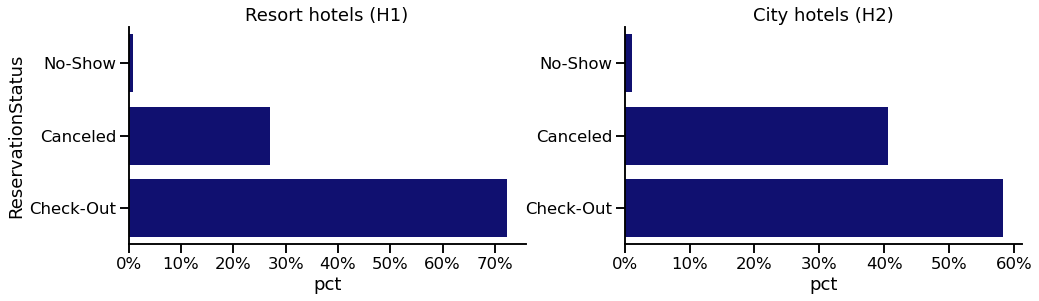

In [11]:
h1_resv_status = df_h1.groupBy('ReservationStatus').count().orderBy('count').toPandas()
h1_resv_status['pct'] = h1_resv_status['count'] / h1_resv_status['count'].sum()

h2_resv_status = df_h2.groupBy('ReservationStatus').count().orderBy('count').toPandas()
h2_resv_status['pct'] = h2_resv_status['count'] / h2_resv_status['count'].sum()

f, ax = plt.subplots(figsize = (16, 4), ncols = 2)
plt.subplots_adjust(wspace = .25)

sns.barplot(
    data = h1_resv_status,
    y = 'ReservationStatus',
    x = 'pct',
    orient = 'h',
    color = 'navy',
    ax = ax[0]
)
ax[0].set_title('Resort hotels (H1)')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

sns.barplot(
    data = h2_resv_status,
    y = 'ReservationStatus',
    x = 'pct',
    orient = 'h',
    color = 'navy',
    ax = ax[1]
)
ax[1].set_title('City hotels (H2)')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].set_ylabel('')

sns.despine();

In [12]:
del h1_resv_status, h2_resv_status

### Distribution by country

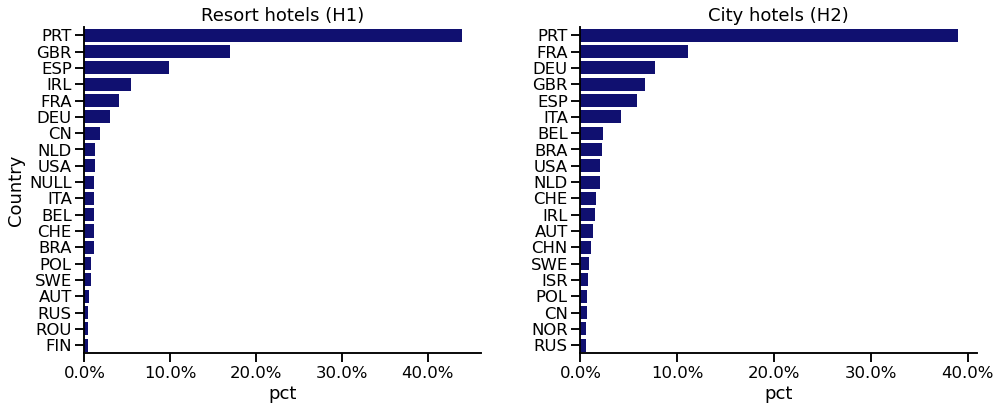

In [13]:
h1_country = df_h1.groupBy('Country').count().orderBy('count', ascending = False).toPandas()
h1_country['pct'] = h1_country['count'] / h1_country['count'].sum()

h2_country = df_h2.groupBy('Country').count().orderBy('count', ascending = False).toPandas()
h2_country['pct'] = h2_country['count'] / h2_country['count'].sum()

n = 20
f, ax = plt.subplots(figsize = (16, 6), ncols = 2)
plt.subplots_adjust(wspace = .25)

sns.barplot(
    data = h1_country.head(n),
    y = 'Country',
    x = 'pct',
    orient = 'h',
    color = 'navy',
    ax = ax[0]
)
ax[0].set_title('Resort hotels (H1)')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

sns.barplot(
    data = h2_country.head(n),
    y = 'Country',
    x = 'pct',
    orient = 'h',
    color = 'navy',
    ax = ax[1]
)
ax[1].set_title('City hotels (H2)')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].set_ylabel('')

sns.despine();

### Cancelled bookings by week of year

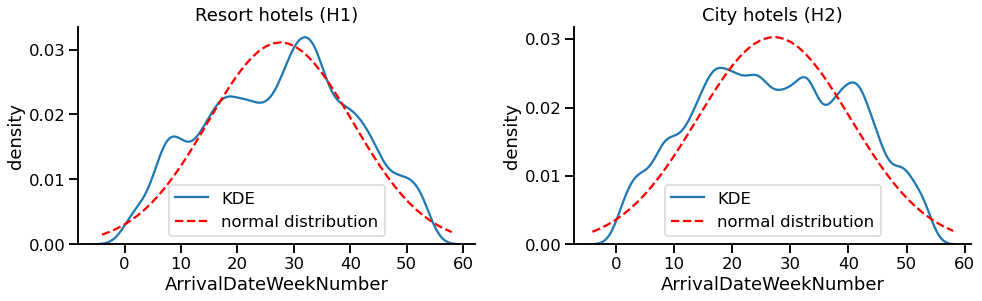

In [45]:
from scipy.stats import norm

f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .25)

## fit a normal distribution
x1 = df_h1.filter('IsCanceled == 1').select('ArrivalDateWeekNumber').toPandas()['ArrivalDateWeekNumber']
## set x-axis value range
support = np.linspace(np.min(x1) - 5, np.max(x1) + 5)

sns.kdeplot(
    x1,
    ax = ax[0],
    label = 'KDE'
);
ax[0].plot(
    support,
    norm.pdf(support, *norm.fit(x1)),
    linestyle = '--',
    color = 'red',
    label = 'normal distribution'
)

x2 = df_h2.filter('IsCanceled == 1').select('ArrivalDateWeekNumber').toPandas()['ArrivalDateWeekNumber'] 
support = np.linspace(np.min(x2) - 5, np.max(x2) + 5)
sns.kdeplot(
    x2,
    ax = ax[1],
    label = 'KDE'
);
ax[1].plot(
    support,
    norm.pdf(support, *norm.fit(x2)),
    linestyle = '--',
    color = 'red',
    label = 'normal distribution'
)

ax[0].set_title("Resort hotels (H1)")
ax[1].set_title("City hotels (H2)")
ax[0].set_ylabel('density')
ax[1].set_ylabel('density')

ax[0].legend(loc = 'best')
ax[1].legend(loc = 'best')
sns.despine();

### Cancelled bookings by day of month

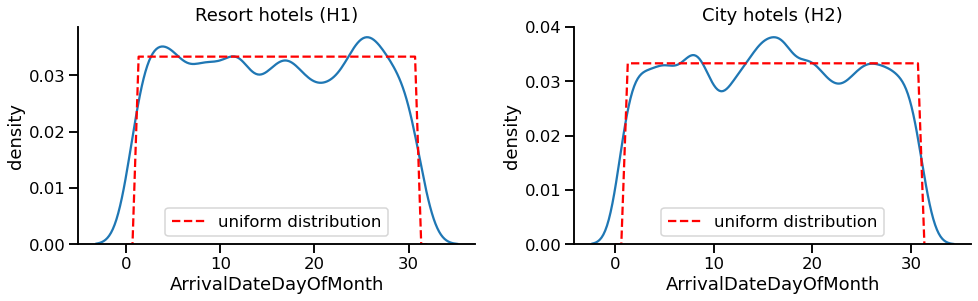

In [51]:
from scipy.stats import uniform

f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .25)

## fit a reference distribution
x1 = df_h1.filter('IsCanceled == 1').select('ArrivalDateDayOfMonth').toPandas()['ArrivalDateDayOfMonth']
## set x-axis value range
support = np.linspace(np.min(x1)-1, np.max(x1)+1)

sns.kdeplot(
    x1,
    ax = ax[0]
);
## plot the reference distribution
ax[0].plot(
    support,
    uniform.pdf(support, *uniform.fit(x1)),
    linestyle = '--',
    color = 'red',
    label = 'uniform distribution'
)

## fit a reference distribution
x2 = df_h2.filter('IsCanceled == 1').select('ArrivalDateDayOfMonth').toPandas()['ArrivalDateDayOfMonth']
## set x-axis value range
support = np.linspace(np.min(x2)-1, np.max(x2)+1)

sns.kdeplot(
    x2,
    ax = ax[1]
);
## plot the reference distribution
ax[1].plot(
    support,
    uniform.pdf(support, *uniform.fit(x2)),
    linestyle = '--',
    color = 'red',
    label = 'uniform distribution'
)

ax[0].set_title("Resort hotels (H1)")
ax[1].set_title("City hotels (H2)")
ax[0].set_ylabel('density')
ax[1].set_ylabel('density')
ax[0].legend(loc = 'best')
ax[1].legend(loc = 'best')
sns.despine();

### ADR 

#### ADR based on cancellation status

H2 dataset has a record with extremely high ADR.

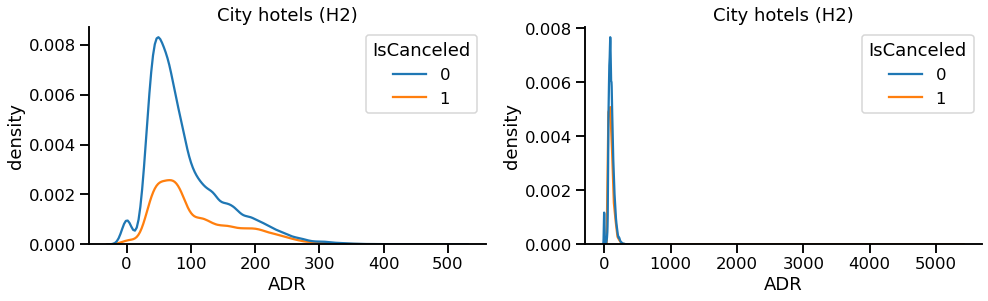

In [16]:
f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .25)

sns.kdeplot(
    data = df_h1.select(['IsCanceled','ADR']).toPandas(),
    x = 'ADR',
    hue = 'IsCanceled',
    ax = ax[0]
)
ax[0].set_ylabel("density")
ax[0].set_title("City hotels (H2)")

sns.kdeplot(
    data = df_h2.select(['IsCanceled','ADR']).toPandas(),
    x = 'ADR',
    hue = 'IsCanceled',
    ax = ax[1]
)

ax[1].set_ylabel("density")
ax[1].set_title("City hotels (H2)")
sns.despine();

#### ADR by distribution channel

An outlier is found on TA/TO distribution channel.

### Lead Time

#### Lead Time by Cancellation Status

#### Lead Time by Distribution Channel

Cancelled reservations tend to have a longer lead time. TA/TO has a wider lead time range compared to other distribution channels.

#### ADR, LeadTime, DaysInWaitingList by distribution channel and market segment

In [16]:
# df_h1.groupBy(['DistributionChannel','MarketSegment']).describe().show()
# df_h1.groupBy(['DistributionChannel','MarketSegment']).mean().show()

# import pyspark.sql.functions as F

# df_h1.agg(
#     F.expr('percentile_approx(val, 0.5)')
# )

+-------------------+-------------+--------------------+------------------+--------------------+--------------------------+--------------------------+-------------------------+----------------------+------------------+--------------------+--------------------+--------------------+--------------------------+--------------------------------+-------------------+----------------------+------------------+-----------------------------+---------------------------+
|DistributionChannel|MarketSegment|     avg(IsCanceled)|     avg(LeadTime)|avg(ArrivalDateYear)|avg(ArrivalDateWeekNumber)|avg(ArrivalDateDayOfMonth)|avg(StaysInWeekendNights)|avg(StaysInWeekNights)|       avg(Adults)|       avg(Children)|         avg(Babies)|avg(IsRepeatedGuest)|avg(PreviousCancellations)|avg(PreviousBookingsNotCanceled)|avg(BookingChanges)|avg(DaysInWaitingList)|          avg(ADR)|avg(RequiredCarParkingSpaces)|avg(TotalOfSpecialRequests)|
+-------------------+-------------+--------------------+------------------+-

### Correlation of numeric values

### Distribution of numeric values

## 2.4. Data Quality Assessment

### 2.4.1. Inconsistent coding scheme

At a glance, there is no inconsistent coding scheme in both datasets. However, actually the Undefined Meal value refers to the same meaning of SC (refer to the metadata explanation). We'll sort them out on the Data Cleaning part.

### 2.4.2. Data error: extreme values and outliers

Assumption: outliers if values are:

- $< Q1 - 1.5 * IQR$, or 
- $> Q3 + 1.5 * IQR$

In [9]:
def check_outliers(series):
    """
    Return number of outliers in the series.
    Outliers: if < Q1 - 1.5*IQR or > Q3 + 1.5*IQR
    """
    q1, q3 = np.percentile(series, q=[25, 75])
    iqr = q3 - q1
    lower_threshold = q1 - (1.5 * iqr)
    upper_threshold = q3 + (1.5 * iqr)
    conditions = [
        (series < lower_threshold) | (series > upper_threshold)
    ]
    choice = [1]
    outliers_flag = np.select(conditions, choice, default = 0)
    return sum(outliers_flag)

### 2.4.3. Missing values